A network for detecting dominant instrument from the mel-spectogram of an audio file, trained on the IRMAS dataset.

# Imports and macros

In [1]:
from IPython.display import Audio
import librosa
from librosa.display import specshow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import random
from tqdm import tqdm

In [2]:
train_path = 'data/IRMAS-TrainingData'
NUM_CLASSES = 11
CLS_NAMES = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
fourier_window = 2048

In [3]:
# Play random sample
sample_path = os.path.join(train_path, 'sax/118__[sax][nod][jaz_blu]1702__3.wav')
Audio(sample_path)

# Utility Functions

In [8]:
def generate_spectogram(filename):
    out_rate = 22050
    n_mel_bands = 128
    segment_dur = 43
    # Load audio
    audio, sr = librosa.load(filename)
    # Normalize the Audio
    audio = audio/np.max(audio)
    # Get log mel spectogram
    melspectr = librosa.feature.melspectrogram(y=audio, sr=out_rate, n_mels=n_mel_bands, fmax=out_rate/2)
    logmelspectr = librosa.logamplitude(melspectr**2, ref_power=1.0)
    
    rand_idx = random.randint(0, logmelspectr.shape[1]-segment_dur + 1)
    return logmelspectr[:, rand_idx:rand_idx + segment_dur]
    

In [10]:
spec = generate_spectogram(sample_path)

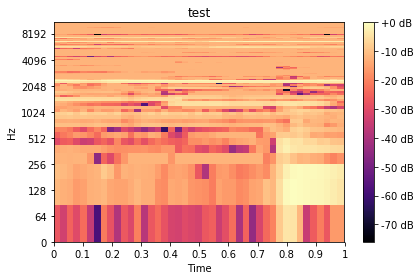

In [11]:
display_spectogram(spec, "test")

In [5]:
def display_spectogram(spec, name):
    spec = np.squeeze(np.copy(spec))
    specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time')
    plt.title(name)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [6]:
def preprocess_specs(spec):
    
    # transpose and reshape specs to form tf.nn.conv2d expects
    spec = spec.T
    spec = np.expand_dims(spec, 2)
    
    return spec

In [6]:
def data_generator(batch_size=1):
    
    # Compile list of filenames
    files_dict = {}
    for cls in CLS_NAMES:
        folder_path = os.path.join(train_path, cls)
        files_dict[cls] = glob.glob(os.path.join(folder_path, "*.wav"))

    while(True):
        batch = np.empty((batch_size, 43, 128, 1))
        gt = np.zeros((batch_size, NUM_CLASSES))
        for i in range(batch_size):
            # Put in spectogram of random file
            cls = random.choice(CLS_NAMES)
            file = random.choice(files_dict[cls])
            spec = generate_spectogram(file)
            spec = preprocess_specs(spec)
            while (spec.shape[0] < 43):
                cls = random.choice(CLS_NAMES)
                file = random.choice(files_dict[cls])
                spec = generate_spectogram(file)
                spec = preprocess_specs(spec)
            batch[i, :, :, :] = spec
            gt[i, CLS_NAMES.index(cls)] = 1.0
        yield batch, gt

In [7]:
def interpret_prediction(index):
    
    return CLS_NAMES[index]

In [8]:
def interpret_gt(gt):
    
    ind = np.squeeze(np.argmax(gt, axis=1))
    return CLS_NAMES[ind]

# Construct model

In [9]:
# def selu(x):
#     with ops.name_scope('elu') as scope:
#         alpha = 1.6732632423543772848170429916717
#         scale = 1.0507009873554804934193349852946
#         return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [17]:
def conv_layer(layer_input, input_fsize, output_fsize, filter_size, bn, name):
        w = tf.get_variable(name+"_w", shape=[filter_size, filter_size, input_fsize, output_fsize], 
                            initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                            regularizer=tf.contrib.layers.l2_regularizer(.001))
        b = tf.Variable(tf.constant(0.0, shape=[output_fsize]), name=name+"_b")
        layer = tf.nn.elu(tf.add(tf.nn.conv2d(layer_input, w, strides=[1,1,1,1], padding="SAME"), b), name=name)
        return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=bn)

In [18]:
def build_model(in_layer, filter_size=3, pool_size=3, bn=True, keep_prob=1.0):
    
    conv1 = conv_layer(in_layer, 1, 32, filter_size, bn, "conv1")
    conv2 = conv_layer(conv1, 32, 32, filter_size, bn, "conv2")
    pool1 = tf.nn.max_pool(conv2, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME', name="pool1")
    drop1 = tf.nn.dropout(pool1, keep_prob)
    conv3 = conv_layer(drop1, 32, 64, filter_size, bn, "conv3")
    conv4 = conv_layer(conv3, 64, 64, filter_size, bn, "conv4")
    pool2 = tf.nn.max_pool(conv4, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME', name="pool2")
    drop2 = tf.nn.dropout(pool2, keep_prob)
    conv5 = conv_layer(drop2, 64, 128, filter_size, bn, "conv5")
    conv6 = conv_layer(conv5, 128, 128, filter_size, bn, "conv6")
    pool3 = tf.nn.max_pool(conv6, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME', name="pool3")
    drop3 = tf.nn.dropout(pool3, keep_prob)
    conv7 = conv_layer(drop3, 128, NUM_CLASSES, filter_size, bn, "conv7")
    logits = tf.reduce_max(conv7, axis=[1,2])
    return logits

In [ ]:
def build_model2(in_layer, filter_size=3, pool_size=3, bn=True, keep_prob=1.0):
    
    conv1 = conv_layer(in_layer, 1, 32, filter_size, bn, "conv1")
    conv2 = conv_layer(conv1, 32, 32, filter_size, bn, "conv2")
    pool1 = tf.nn.max_pool(conv2, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME', name="pool1")
    drop1 = tf.nn.dropout(pool1, keep_prob)
    conv3 = conv_layer(drop1, 32, 64, filter_size, bn, "conv3")
    conv4 = conv_layer(conv3, 64, 64, filter_size, bn, "conv4")
    pool2 = tf.nn.max_pool(conv4, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME', name="pool2")
    drop2 = tf.nn.dropout(pool2, keep_prob)
    conv5 = conv_layer(drop2, 64, 128, filter_size, bn, "conv5")
    conv6 = conv_layer(conv5, 128, 128, filter_size, bn, "conv6")
    pool3 = tf.nn.max_pool(conv6, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME', name="pool3")
    drop3 = tf.nn.dropout(pool3, keep_prob)
    conv7 = conv_layer(drop3, 128, 256, filter_size, bn, "conv7")
    conv8 = conv_layer(conv7, 256, 256, filter_size, bn, "conv8")
    pool4 = tf.reduce_max(conv8, axis=[1,2])
    
    return logits

In [19]:
class model:
    
    def __init__(self, batch_size=1, filter_size=3, pool_size=2):
                
        # Build model
        # Placeholders
        self.X = tf.placeholder(tf.float32, shape=None, name="input")
        self.y = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name="gt")
        self.bn = tf.placeholder(tf.bool, name="bn")
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        
        self.logits = build_model(self.X, filter_size=3, pool_size=2, bn=self.bn, keep_prob=self.keep_prob)
        
        self.loss = self.get_loss(self.logits)
        
        self.soft = tf.nn.softmax(self.logits)
        self.result = tf.squeeze(tf.argmax(self.soft, axis=-1))
        self.accuracy = tf.equal(self.result, tf.squeeze(tf.argmax(self.y, axis=1)))
    
    def get_loss(self, logits):
        
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.y))
        
        reg_loss = sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        loss += reg_loss
        
        return loss
    
    def save(self, sess, model_path):
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def predict(self, spec, model_path=None, restore=True):
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            if restore:
                self.restore(sess, model_path)
            
            prediction, logits = sess.run([self.result, self.logits], feed_dict={self.X: spec,
                                                         self.bn: False, self.keep_prob: 1.0})

        return prediction, logits
    
    def train(self, data_gen, model_path, iters=10, learning_rate=1e-3, display=1, restore=False, keep_prob=0.25):
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            
            print("Starting training")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)
            
            total_acc = 0.0
            total_loss = 0.0
            
            for step in range(iters):
                
                batch, gt = next(data_gen)
                
                _, loss, acc, logits = sess.run((self.optimizer, self.loss, self.accuracy, self.logits),
                                                    feed_dict={self.X: batch,
                                                              self.y: gt,
                                                              self.bn: True,
                                                              self.keep_prob: keep_prob})
                
                total_loss += loss
                total_acc += acc
                
                if (step+1) % display == 0:
                    
                    print("At iteration %d loss equals %.2f and accuracy equals %.2f" % (step+1, total_loss/(step+1), total_acc/(step+1)))
                    
            print("TRAINING FINISHED")
            
            save_path = self.save(sess, model_path)
        
        return save_path
        

# Train model

In [24]:
tf.reset_default_graph()

In [25]:
# instr_id is at 40-something accuracy and id is currently at 16
model_path = 'model/id.ckpt'
data_gen = data_generator()

In [26]:
my_model = model()

In [27]:
model_path = my_model.train(data_gen, model_path, iters=15000,
                            learning_rate=8e-4, display=500,
                            restore=True)

Starting training
INFO:tensorflow:Restoring parameters from model/id.ckpt
At iteration 500 loss equals 2.35 and accuracy equals 0.12
At iteration 1000 loss equals 2.36 and accuracy equals 0.14
At iteration 1500 loss equals 2.36 and accuracy equals 0.14
At iteration 2000 loss equals 2.35 and accuracy equals 0.14
At iteration 2500 loss equals 2.35 and accuracy equals 0.14
At iteration 3000 loss equals 2.34 and accuracy equals 0.15
At iteration 3500 loss equals 2.34 and accuracy equals 0.15
At iteration 4000 loss equals 2.34 and accuracy equals 0.15
At iteration 4500 loss equals 2.34 and accuracy equals 0.15
At iteration 5000 loss equals 2.34 and accuracy equals 0.15
At iteration 5500 loss equals 2.33 and accuracy equals 0.15
At iteration 6000 loss equals 2.33 and accuracy equals 0.15
At iteration 6500 loss equals 2.33 and accuracy equals 0.15
At iteration 7000 loss equals 2.33 and accuracy equals 0.15
At iteration 7500 loss equals 2.33 and accuracy equals 0.15
At iteration 8000 loss equa

# Test model

In [176]:
tf.reset_default_graph()

In [177]:
my_model = model()

In [178]:
batch, gt = next(data_gen)

In [179]:
result, logits = my_model.predict(spec=batch, model_path=model_path, restore=True)

INFO:tensorflow:Restoring parameters from model/id.ckpt


In [180]:
interpret_prediction(result)

'voi'

In [181]:
interpret_gt(gt)

'cel'